In [1]:
import numpy as np
import jax.random
import jax.numpy as jnp
import jax.scipy.optimize
import jaxopt
import optax
jax.config.update("jax_enable_x64", True)

import pennylane as qml
from shapely.geometry import Polygon, Point
from functools import partial

from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
plt.ioff()

import time
import pandas as pd
from datetime import datetime
import os
import pytz
import ast
from pypdf import PdfMerger

import contextlib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Running parameters
num_iters = 10    # Number of training iterations
num_runs = 2
cl_types = ["NCL", "CL", "ACL", "SPCL", "SPACL"]     # "NCL" - No curriculum, "CL" - Curriculum, "ACL" - Anti-curriculum, "SPCL" - Self paced curriculum, "SPACL" - Self paced anti-curriculum
with_val = True
device = "lightning.qubit" # "default.qubit" or "lightning.qubit"

# Circuit and optimization parameters
nqubits = 6         # Num qubits, min 4, always 2**num_layers qubits
optimizer = "Adam"  # "Adam", "GradientDescent", "BFGS"
loss_type = "fidelity" # "fidelity"
initialization = "gaussian" # "gaussian", "uniform"

# Data hyper-parameters
batch_size = 15     # batch training size
train_size = 15      # Total ground states that will be used for training
val_size = 100      # Total gound states with training + validation
cl_batch_ratios = [0.3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]  #[0.4, 0.3, 0.2, 0.1]    # [0.1, 0.2, 0.3, 0.4], [0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], [0.3, 0.2, 0.2, 0.2, 0.1]
cl_iter_ratios  = [0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2]

# Tweak training hyper-parameters
max_weight_init = 2*np.pi  # weight_init goes from 0 to this number. Max = 2*np.pi. Other options = 0.01
stepsize = 0.01         # stepsize of the gradient descent.

# Constant definitions
layers = int(np.log2(nqubits))
nweights = 30*(layers-1) + 15

cl_batches = []
i_batch_size = 0
for i in range(len(cl_iter_ratios)):
    if i < len(cl_iter_ratios)-1:
        i_batch_size += int(cl_batch_ratios[i]*train_size)
        i_num_iters = int(cl_iter_ratios[i]*num_iters)
    else:
        i_batch_size = train_size
        i_num_iters = num_iters - len(cl_batches)
        
    cl_batches += [i_batch_size]*i_num_iters

# Generate dataset

In [3]:
def X(i):
    return qml.PauliX(i)

def Y(i):
    return qml.PauliY(i)

def Z(i):
    return qml.PauliZ(i)

In [428]:
dev = qml.device(device, wires=nqubits)
# @jax.jit
@qml.qnode(dev)
def hamiltonian_evolution(ini_state):
    qubits = list(range(nqubits))
    qml.QubitStateVector(ini_state, wires=qubits)
    hamiltonian = sum(X(i) @ X((i+1)) + Y(i) @ Y((i+1)) + 1.5 * Z(i) @ Z((i+1)) for i in range(nqubits-1))
    qml.ApproxTimeEvolution(hamiltonian, time=1, n=100)
    return qml.state()

# @jax.jit
def get_random_basis_state(key):
    key, subkey = jax.random.split(key)
    choice_arr = jnp.array([1]+[0]*(2**nqubits-1))
    state = jax.random.choice(subkey, choice_arr, shape=(2**nqubits,), replace=False)
    return state, key
    

def generate_dataset(num_points, key):
    dataset = []
    while len(dataset) < num_points:
        ini_state, key = get_random_basis_state(key)
        out_state = hamiltonian_evolution(ini_state)
        dataset.append([ini_state, out_state])
    return dataset, key

# hamiltonian = sum(X(i) @ X((i+1)) + Y(i) @ Y((i+1)) + 1.5 * Z(i) @ Z((i+1)) for i in range(nqubits-1))
# unitary = qml.ApproxTimeEvolution(hamiltonian, time=1, n=100)
# matrix = qml.matrix(unitary)

# clean_matrix = np.array([[v if np.abs(v) > 10**(-10) else 0 for v in r] for r in matrix])

# data = pd.DataFrame(clean_matrix)
# data_file_name = f"Unitary matrix.csv"
# data.to_csv(data_file_name, index=False, header=False)

# frob = np.linalg.norm(clean_matrix - id)
# print(frob)
nqubits = 6
id = np.identity(2**nqubits)

t = time.time()
key = jax.random.PRNGKey(int((t-int(t))*10**10))
dataset, key = generate_dataset(15, key)

dataset


[[Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],      dtype=int64),
  Array([-2.76575153e-16-1.18528336e-16j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,  4.05412916e-02+7.15276329e-02j,
          0.00000000e+00+0.00000000e+00j,  5.72404801e-02-3.48244537e-01j,
         -1.21545538e-01+2.54760282e-01j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j,  2.17844886e-02+7.38327948e-02j,
          2.84974182e-01-5.15765386e-02j,  0.00000000e+00+0.00000000e+00j,
         -1.93591274e-01+4.44048889e-02j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, -1.70113138e-17+1.74456918e-16j,
          0.00000000e+00+0.00000000e+00j,  8.82142925e-02+2.75449343e-01j,
         -3.51736765e-01+1.52661980e-01j,  0.00000000e+00+0.00000000e+00j,
          2

# CNN

In [35]:
# @jax.jit
def general_unitary_2q(q1, q2, weights):
    qml.U3(wires=q1, theta=weights[0], phi=weights[1], delta=weights[2])
    qml.U3(wires=q1, theta=weights[3], phi=weights[4], delta=weights[5])
    qml.CNOT(wires=[q2, q1])
    qml.RZ(wires=q1, phi=weights[6])
    qml.RY(wires=q2, phi=weights[7])
    qml.CNOT(wires=[q1, q2])
    qml.RY(wires=q2, phi=weights[8])
    qml.CNOT(wires=[q2, q1])
    qml.U3(wires=q1, theta=weights[9], phi=weights[10], delta=weights[11])
    qml.U3(wires=q1, theta=weights[12], phi=weights[13], delta=weights[14])
    
# @jax.jit
def variational_unitary(weights):
    k = 0
    for _ in range(layers//2):
        
        i = 0
        while 2*i+1 < nqubits:
            general_unitary_2q(2*i, 2*i+1, weights[k:k+15])
            k += 15
            
        i = 0
        while 2*i+2 < nqubits:
            general_unitary_2q(2*i+1, 2*i+2, weights[k:k+15])
            k += 15
    
    if layers % 2 != 0:
        i = 0
        while 2*i+1 < nqubits:
            general_unitary_2q(2*i, 2*i+1, weights[k:k+15])
            k += 15


dev = qml.device(device, wires=nqubits)
# @jax.jit
@qml.qnode(dev, interface="jax", diff_method="best")
def variational_circuit(weights, state_ini):
    qml.QubitStateVector(state_ini, wires=list(range(nqubits)))
    variational_unitary(weights)
    return qml.state()

# Loss and accuracy

In [38]:
@jax.jit
def single_loss(weights, ini_state, target):
    
    out_state = variational_circuit(weights, ini_state)

    if loss_type == "fidelity":
        cost = 1 - jnp.linalg.norm(proj)**2 - 2*proj[label]
    
    return cost



@jax.jit
def loss(weights_and_bias, ground_states, labels):
    weights = weights_and_bias
    bias = np.array([0.0]*4)
        
    costs = jax.vmap(single_loss, in_axes=[None, None, 0, 0])(weights, bias, ground_states, labels)
    return costs.sum()/len(labels)

In [39]:
@jax.jit
def single_pred(weights, bias, ground_state):
    projectors = variational_classifier(weights, bias, ground_state)
    return np.argmax(projectors)

@jax.jit
def pred(weights, bias, ground_states):
    predictions = jax.vmap(single_pred, in_axes=[None, None, 0])(weights, bias, ground_states)
    return predictions

@jax.jit
def acc(predictions, labels):
    return sum(predictions==labels)*100/len(labels)

# Processing Data

In [40]:
def save_multi_image(filename):
    pp = PdfPages(filename)
    fig_nums = plt.get_fignums()
    figs = [plt.figure(n) for n in fig_nums]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()

def close_all_figures():
    fig_nums = plt.get_fignums()
    for n in fig_nums:
        plt.figure(n)
        plt.close()

        
def save_plots(time_now,
               folder_name,
               file_name,
               plot_run,
               it_max,
               acc_train,
               acc_val,
               losses,
               pred_train,
               pred_val,
               j_train,
               j_val
              ):


    fig, axis = plt.subplots(1,3)
    fig.set_figheight(6.5)
    fig.set_figwidth(20)
    fig.tight_layout(pad=2, w_pad=3.5)

    # ---------------------------------------------------------------------- #
    # -------------------- Loss and accuracy figure ------------------------ #
    # ---------------------------------------------------------------------- #

    iterations = range(1, num_iters+1)

    color1 = 'darkred'
    axis[0].set_xlabel('Iterations')
    axis[0].set_ylabel('Accuracy %', color=color1)
    axis[0].plot(iterations, acc_train, label="Training", color=color1)
    axis[0].plot(iterations, acc_val, '-.', label="Validation", color=color1)
    axis[0].tick_params(axis='y', labelcolor=color1)
    axis[0].set_ylim(0,100)

    ax2 = axis[0].twinx()  # instantiate a second axes that shares the same x-axis

    color2 = 'darkblue'
    ax2.set_ylabel('Loss', color=color2)  # we already handled the x-label with axis[0]
    ax2.plot(iterations, losses, label="Loss", color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    # ax2.set_ylim(bottom=0)

    # fig.tight_layout()  # otherwise the right y-label is slightly clipped
    # plt.legend()
    axis[0].set_title(f"Accuracy and Loss - Run {plot_run}")


    # ----------------------------------------------------------------------------- #
    # ---------------------------- Training points -------------------------------- #
    # ----------------------------------------------------------------------------- #

    plot_iter = num_iters-1

    # define regions coordinates
    x01, y01 = region01_coords[:,0], region01_coords[:,1]
    x02, y02 = region02_coords[:,0], region02_coords[:,1]
    x1, y1 = region1_coords[:,0], region1_coords[:,1]
    x2, y2 = region2_coords[:,0], region2_coords[:,1]
    x3, y3 = region3_coords[:,0], region3_coords[:,1]

    # put the regions into the plot
    axis[1].fill(x01, y01, facecolor='lightskyblue')    # class 0
    axis[1].fill(x02, y02, facecolor='lightskyblue')    # class 0
    axis[1].fill(x1, y1, facecolor='sandybrown')        # class 1
    axis[1].fill(x2, y2, facecolor='salmon')            # class 2
    axis[1].fill(x3, y3, facecolor='lightgreen')        # class 3

    pred_train_plot = np.array(pred_train[plot_iter])
    pred_val_plot = np.array(pred_val[plot_iter])

    colors = ["b", "orange", "r", "g"]

    # plot datapoints
    for i in range(4):
        axis[1].scatter(
            j_train[:, 0][pred_train_plot==i],
            j_train[:, 1][pred_train_plot==i],
            c=colors[i],
            marker="o",
            edgecolors="k",
            label=f"class {i+1} train",
        )
        # if with_val:
        #     axis[1].scatter(
        #         j_val[:, 0][pred_val_plot==i],
        #         j_val[:, 1][pred_val_plot==i],
        #         c=colors[i],
        #         marker="^",
        #         edgecolors="k",
        #         label=f"class {i+1} validation",
        #     )


    # plt.legend()
    axis[1].set_title(f"Training ({acc_train[plot_iter]:.0f}%)")


    # ------------------------------------------------------------------------------ #
    # ---------------------------- Validation points ------------------------------- #
    # ------------------------------------------------------------------------------ #


    plot_iter = num_iters-1

    # define regions coordinates
    x01, y01 = region01_coords[:,0], region01_coords[:,1]
    x02, y02 = region02_coords[:,0], region02_coords[:,1]
    x1, y1 = region1_coords[:,0], region1_coords[:,1]
    x2, y2 = region2_coords[:,0], region2_coords[:,1]
    x3, y3 = region3_coords[:,0], region3_coords[:,1]

    # put the regions into the plot
    axis[2].fill(x01, y01, facecolor='lightskyblue')    # class 0
    axis[2].fill(x02, y02, facecolor='lightskyblue')    # class 0
    axis[2].fill(x1, y1, facecolor='sandybrown')        # class 1
    axis[2].fill(x2, y2, facecolor='salmon')            # class 2
    axis[2].fill(x3, y3, facecolor='lightgreen')        # class 3

    pred_train_plot = np.array(pred_train[plot_iter])
    pred_val_plot = np.array(pred_val[plot_iter])

    colors = ["b", "orange", "r", "g"]

    # plot datapoints
    for i in range(4):
        # axis[2].scatter(
        #     j_train[:, 0][pred_train_plot==i],
        #     j_train[:, 1][pred_train_plot==i],
        #     c=colors[i],
        #     marker="o",
        #     edgecolors="k",
        #     label=f"class {i+1} train",
        # )
        if with_val:
            axis[2].scatter(
                j_val[:, 0][pred_val_plot==i],
                j_val[:, 1][pred_val_plot==i],
                c=colors[i],
                marker="^",
                edgecolors="k",
                label=f"class {i+1} validation",
            )


    # plt.legend()
    axis[2].set_title(f"Validation ({acc_val[plot_iter]:.0f}%)")

    # ---------------------------------------------------------------------- #
    # --------------------------- Save plots ------------------------------- #
    # ---------------------------------------------------------------------- #

    plots_pdf_name = f"{folder_name}/{time_now} - Plots - {file_name}.pdf"
    
    
    # If the file doesn't exist we save it. If it does, we merge it.
    if not os.path.isfile(plots_pdf_name):
        save_multi_image(plots_pdf_name)
    
    else:
        save_multi_image(plots_pdf_name + "2")
        # Merge the new plot with the rest and delete the last file
        merger = PdfMerger()
        merger.append(plots_pdf_name)
        merger.append(plots_pdf_name + "2")
        merger.write(plots_pdf_name)
        merger.close()
        os.remove(plots_pdf_name + "2")
    
    close_all_figures()

In [41]:
def save_hyperparameters(time_now, folder_name, file_name):
    
    # --------------- Hyperparameters -----------------#
    hyperparameters = {}
    hyperparameters["num_iters"] = [num_iters]
    hyperparameters["num_runs"] = [num_runs]
    hyperparameters["cl_types"] = [cl_types]
    hyperparameters["with_val"] = [with_val]
    hyperparameters["nqubits"] = [nqubits]
    hyperparameters["optimizer"] = [optimizer]
    hyperparameters["loss_type"] = [loss_type]
    hyperparameters["initialization"] = [initialization]
    hyperparameters["batch_size"] = [batch_size]
    hyperparameters["train_size"] = [train_size]
    hyperparameters["val_size"] = [val_size]
    hyperparameters["cl_batch_ratios"] = [cl_batch_ratios]
    hyperparameters["cl_iter_ratios"] = [cl_iter_ratios]
    hyperparameters["max_weight_init"] = [max_weight_init]
    hyperparameters["stepsize"] = [stepsize]
    hyperparameters["key"] = [time_now]

    hyperparameters = pd.DataFrame(hyperparameters)

    hyperparameters_file_name = f"{folder_name}/{time_now} - Hyperparameters{file_name}.csv"
    hyperparameters.to_csv(hyperparameters_file_name, index=False)

In [42]:
def save_data(time_now,
                folder_name,
                run,
                weights,
                bias,
                losses,
                j_train,
                j_val,
                pred_train,
                pred_val,
                acc_train,
                acc_val,
                run_time,
                cl
               ):
    
    # -------------------- Total Data -------------------- #
    data = {}
    data["run"] = run
    
    it_max = np.argmax(np.array(acc_train))
    acc_train_max = acc_train[it_max]
    acc_train_last = acc_train[num_iters-1]
    acc_val_max = acc_val[it_max]
    acc_val_last = acc_val[num_iters-1]
    
    data["it_max"] = it_max
    data["acc_train_max"] = acc_train_max
    data["acc_train_last"] = acc_train_last
    data["acc_val_max"] = acc_val_max
    data["acc_val_last"] = acc_val_last
    data["run_time"] = run_time
    
    data["weights"] = [weights]
    data["bias"] = [bias]
    data["losses"] = [losses]
    data["j_train"] = [j_train.tolist()]
    data["j_val"] = [j_val.tolist()]
    data["pred_train"] = [pred_train]
    data["pred_val"] = [pred_val]
    data["acc_train"] = [acc_train]
    data["acc_val"] = [acc_val]
    

    data = pd.DataFrame(data)
    
    data_file_name = f"{folder_name}/{time_now} - Data - {cl}.csv"
    data.to_csv(data_file_name, index=False, mode='a', header = not os.path.exists(data_file_name))
    
    
    # ------------------- Results ------------------- #
    
    read_data = pd.read_csv(data_file_name,
                     usecols=["it_max",
                              "acc_train_max",
                              "acc_val_max",
                              "acc_train",
                              "acc_val"],
                     converters={"acc_train":ast.literal_eval,
                                 "acc_val":ast.literal_eval})
    
    total_it_max = read_data["it_max"]
    total_acc_train_max = read_data["acc_train_max"]
    total_acc_val_max = read_data["acc_val_max"]
    total_acc_train = read_data["acc_train"].tolist()
    total_acc_val = read_data["acc_val"].tolist()
    
    best_run_max = total_acc_train_max.argmax()
    best_it_max = total_it_max[best_run_max]
    avg_acc_train_max = total_acc_train_max.mean()
    avg_acc_val_max = total_acc_val_max.mean()
    
    best_run_last = np.argmax(np.array(total_acc_train)[:,num_iters-1])
    avg_acc_train_last = np.mean(np.array(total_acc_train)[:,num_iters-1])
    avg_acc_val_last = np.mean(np.array(total_acc_val)[:,num_iters-1])

    results = {}
    results["type_cv"] = [cl]
    results["num_runs"] = [run+1]
    results["best_run_max"] = [best_run_max]
    results["best_run_last"] = [best_run_last]
    results["best_it_max"] = [best_it_max]
    results["best_it_last"] = [num_iters-1]
    results["best_acc_train_max"] = [total_acc_train[best_run_max][best_it_max]]
    results["best_acc_train_last"] = [total_acc_train[best_run_max][num_iters-1]]
    results["best_acc_val_max"] = [total_acc_val[best_run_max][best_it_max]]
    results["best_acc_val_last"] = [total_acc_val[best_run_max][num_iters-1]]
    results["avg_acc_train_max"] = [avg_acc_train_max]
    results["avg_acc_train_last"] = [avg_acc_train_last]
    results["avg_acc_val_max"] = [avg_acc_val_max]
    results["avg_acc_val_last"] = [avg_acc_val_last]
    results = pd.DataFrame(results)

    results_file_name = f"{folder_name}/{time_now} - Results.csv"
    
    # If file exists, we update the info
    if os.path.exists(results_file_name):
        read_results = pd.read_csv(results_file_name)
        row_index = read_results.loc[read_results["type_cv"] == cl].index
        
        if row_index.shape != (0,):
            read_results.drop(labels=row_index[0], axis=0, inplace=True) # we delete the line if it already exists
            
        results = pd.concat([read_results, results], ignore_index=True)
    
    results.to_csv(results_file_name, index=False)
    
    
    
    # ------------------- Plots ------------------- #
    save_plots(time_now,
               folder_name,
               cl,
               run,
               it_max,
               acc_train,
               acc_val,
               losses,
               pred_train,
               pred_val,
               j_train,
               j_val
              )
    
    if cl == "NCL":
        cl_str = "NCL  "
    elif cl=="CL":
        cl_str = "CL   "
    elif cl=="ACL":
        cl_str = "ACL  "
    elif cl=="SPCL":
        cl_str = "SPCL "
    elif cl=="SPACL":
        cl_str = "SPACL"
        
    print(
        f" {cl_str} |"
        f" {run:3d} |"
        f" {it_max:4d}/{num_iters-1:4d} |"
        f"  {acc_train[it_max]:0.0f}/{acc_train[num_iters-1]:0.0f}  |"
        f" {acc_val[it_max]:0.0f}/{acc_val[num_iters-1]:0.0f} |"
        f" {run_time:0.0f}"
    )
    
    

# Training

In [43]:
@jax.jit
def sort_gs(w, b, gs, labels, js, ascending):    
    scores = jax.vmap(single_loss, in_axes=[None, None, 0, 0])(jnp.array(w), jnp.array(b), jnp.array(gs), jnp.array(labels))
    
    p = jnp.where(ascending, scores.argsort(), scores.argsort()[::-1])
    
    return gs[p], labels[p], js[p]

In [44]:
def train_qcnn(gs_train, gs_val, labels_train, labels_val, j_train, opt, cl):
    
    if initialization == "uniform":
        weights_init = np.random.uniform(0, max_weight_init, nweights)
    elif initialization == "gaussian":
        weights_init = np.random.normal(0, 1/np.sqrt(nqubits), nweights)
        
    bias_init = np.array([0.0]*4)
    
    params_init = weights_init
        
    #Initiaize variables
    weights = []
    bias = []
    losses = []
    pred_train_arr = []
    pred_val_arr = []
    acc_train_arr = []
    acc_val_arr = []

    w = weights_init
    b = bias_init
    
    params = params_init
    state = opt.init_state(params_init, gs_train[:2], labels_train[:2])
    
    for it in range(num_iters):
        
        # For self paced learning, we sort the datapoints at every iteration
        if cl in ["SPCL", "SPACL"]:
            ascending = True if cl == "SPCL" else False
            gs_train, labels_train, j_train = sort_gs(w, b, gs_train, labels_train, j_train, ascending)
            
        # Once they are sorted, we select the first datapoints into the batch lists
        if cl in ["CL", "ACL", "SPCL", "SPACL"]:
            gs_train_batch = gs_train[:cl_batches[it]]
            labels_train_batch = labels_train[:cl_batches[it]]
        
        elif cl == "NCL":
            batch_index = np.random.default_rng().choice(len(labels_train), size=batch_size, replace=False)
            
            gs_train_batch = gs_train[batch_index]
            labels_train_batch = labels_train[batch_index]

            
        # Update the weights by one optimizer step
        with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
            params, state = opt.update(params, state, gs_train_batch, labels_train_batch)
        
        w = params
        
        if optimizer == "GradientDescent":
            l = loss(params, gs_train_batch, labels_train_batch)
        else:
            l = state.value
        
        # Compute predictions and accuracy on train and validation set
        pred_train = pred(w, b, gs_train)
        if with_val:
            pred_val = pred(w, b, gs_val) if len(labels_val) > 0 else None
        else:
            pred_val = np.array([0]*len(labels_val))
        
        acc_train = acc(pred_train, labels_train)
        if with_val:
            acc_val = acc(pred_val, labels_val) if len(labels_val) > 0 else 0
        else:
            acc_val = 0
        
        weights.append(w.tolist())
        bias.append(b.tolist())

        # Save prediction for later plotting
        pred_train_arr.append(pred_train.tolist())
        pred_val_arr.append(pred_val.tolist())
        acc_train_arr.append(float(acc_train))
        acc_val_arr.append(float(acc_val))

        # l = loss(w, b, gs_train, labels_train)
        losses.append(float(l))

    return weights, bias, losses, pred_train_arr, pred_val_arr, acc_train_arr, acc_val_arr, j_train

In [45]:
def main():

    # with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):

    time_now = datetime.now(pytz.timezone('Europe/Andorra')).strftime("%Y-%m-%d %H-%M-%S")

    folder_name = f"Results/{nqubits}q - {num_iters:} iters/"
    if not os.path.isdir(f'{folder_name}'):
        os.makedirs(f'{folder_name}')

    save_hyperparameters(time_now, folder_name, file_name="")


    # choose variational classifier
    if optimizer == "GradientDescent":
        opt = jaxopt.GradientDescent(loss, stepsize=stepsize, verbose=False, jit=True)
    elif optimizer == "Adam":
        opt = jaxopt.OptaxSolver(loss, optax.adam(stepsize), verbose=False, jit=True)
    elif optimizer == "BFGS":
        opt = jaxopt.BFGS(loss, verbose=False, jit=True)
    
    
    for run in range (num_runs):
        
        # -------------------------------------------------------------- #
        # ------------------- Generate ground states ------------------- #
        # -------------------------------------------------------------- #
        
        print("Generating ground states...")
        start_time = time.time()

        gs_train, labels_train, j_train = generate_gs(train_size, True, True)
        if with_val:
            gs_val, labels_val, j_val = generate_gs(val_size, True, False)

        run_time = time.time() - start_time

        print(f"Ground states generated - {run_time:.0f}s")
        print()
        print("Max train / Last run")
        print("-------------------------------------------------")
        print("  CL   | Run |   Iter    |Acc train|Acc val| Time  ")
        print("-------------------------------------------------")
        
        
        for cl in cl_types:
            # ----------------------------------------------------------------------------------------------- #
            # ------------------------ Sort training gs by their score if curriculum ------------------------ #
            # ----------------------------------------------------------------------------------------------- #

            if cl in ["CL", "ACL"]:
                score_it = num_iters-1
                ascending = True if cl == "CL" else False
                gs_train, labels_train, j_train = sort_gs(weights_ncl[score_it], bias_ncl[score_it], gs_train, labels_train, j_train, ascending)

            # ------------------------------------------------------------ #
            # ------------------------ Train QCNN ------------------------ #
            # ------------------------------------------------------------ #

            start_time = time.time()

            weights, \
            bias, \
            losses, \
            pred_train_arr, \
            pred_val_arr, \
            acc_train_arr, \
            acc_val_arr, \
            cv_j_train = train_qcnn(gs_train,
                                    gs_val,
                                    labels_train,
                                    labels_val,
                                    j_train,
                                    opt=opt,
                                    cl=cl
                                    )

            run_time = time.time() - start_time
            
            if cl == "NCL":
                weights_ncl = weights
                bias_ncl = bias

            # --------------------------------------------------------- #
            # ------------------- Save calculations ------------------- #
            # --------------------------------------------------------- #
            save_data(time_now,
                    folder_name,
                    run,
                    weights,
                    bias,
                    losses,
                    cv_j_train,
                    j_val,
                    pred_train_arr,
                    pred_val_arr,
                    acc_train_arr,
                    acc_val_arr,
                    run_time,
                    cl=cl
                    )

        print("-------------------------------------------------")
        print()

# Execution

In [46]:
main()

Generating ground states...
Ground states generated - 4s

Max train / Last run
-------------------------------------------------
  CL   | Run |   Iter    |Acc train|Acc val| Time  
-------------------------------------------------
 NCL   |   0 |    6/   9 |  60/60  | 41/44 | 20
 CL    |   0 |    8/   9 |  50/50  | 34/37 | 102
 ACL   |   0 |    1/   9 |  30/20  | 35/30 | 0
 SPCL  |   0 |    9/   9 |  50/50  | 36/36 | 2
 SPACL |   0 |    7/   9 |  90/90  | 58/71 | 0
-------------------------------------------------

Generating ground states...
Ground states generated - 3s

Max train / Last run
-------------------------------------------------
  CL   | Run |   Iter    |Acc train|Acc val| Time  
-------------------------------------------------
 NCL   |   1 |    8/   9 |  60/60  | 54/59 | 0
 CL    |   1 |    7/   9 |  60/60  | 46/46 | 0
 ACL   |   1 |    1/   9 |  30/20  | 35/25 | 0
 SPCL  |   1 |    6/   9 |  40/40  | 49/49 | 0
 SPACL |   1 |    9/   9 |  80/80  | 69/69 | 0
--------------

# Plot sorted points

In [226]:
def plots_sorted_points(nqubits, num_iters, num_runs, time_now, file_name, only_train):
    
    folder_name = f"Results/{nqubits}q - {num_iters:} iters"
    data_file_name = f"{folder_name}/{time_now} - Data - {file_name}.csv"
    
    # Read the saved data #####################
    read_data = pd.read_csv(data_file_name,
                            usecols=["weights",
                                    "bias",
                                    "j_train",
                                    "j_val",
                                    "pred_train",
                                    "pred_val"],
                            converters={"weights":ast.literal_eval,
                                        "bias":ast.literal_eval,
                                        "j_train":ast.literal_eval,
                                        "j_val":ast.literal_eval,
                                        "pred_train":ast.literal_eval,
                                        "pred_val":ast.literal_eval})

    if not only_train:
        j_val = read_data["j_val"][0]
        gs_list_val = []
        labels_list_val = []
        for (j1, j2) in j_val:
            gs_list_val.append(ground_state(j1, j2))
            labels_list_val.append(labeling(j1, j2))


    for run in range(num_runs):
        
        j_train = read_data["j_train"][run]
        gs_list_train = []
        labels_list_train = []
        for (j1, j2) in j_train:
            gs_list_train.append(ground_state(j1, j2))
            labels_list_train.append(labeling(j1, j2))
        
        if only_train:
            js = j_train
            gs_list = gs_list_train
            labels_list = labels_list_train
        else:
            js = j_train + j_val
            gs_list = gs_list_train + gs_list_val
            labels_list = labels_list_train + labels_list_val
        
        last_iter = len(read_data["weights"][run])-1

        weights = read_data["weights"][run][last_iter]
        bias = read_data["bias"][run][last_iter]
        pred_train = read_data["pred_train"][run][last_iter]
        pred_val = read_data["pred_val"][run][last_iter]

        if only_train:
            preds = pred_train
        else:
            preds = pred_train + pred_val

        # Calculate losses #####################
        losses = jax.vmap(single_loss, in_axes=[None, None, 0, 0])(jnp.array(weights), jnp.array(bias), jnp.array(gs_list), jnp.array(labels_list)).tolist()

        # Sort the points by the loss #####################
        table = {}
        table["js"] = js
        table["preds"] = preds
        table["losses"] = losses

        table = pd.DataFrame(table)
        table.sort_values(by=["losses"], inplace=True)

        cv_js = np.array(list(table["js"]))
        cv_preds = np.array(list(table["preds"]))

        # Make the plots #####################

        for i in range(11):
            ratio_ini_points = 0
            ratio_end_points = i/10

            first_point = int(len(cv_js)*ratio_ini_points)
            last_point = int(len(cv_js)*ratio_end_points)

            j_plot = cv_js[first_point:last_point]
            pred_plot = cv_preds[first_point:last_point]

            fig, axis = plt.subplots(1,1)
            
            # define regions coordinates
            x01, y01 = region01_coords[:,0], region01_coords[:,1]
            x02, y02 = region02_coords[:,0], region02_coords[:,1]
            x1, y1 = region1_coords[:,0], region1_coords[:,1]
            x2, y2 = region2_coords[:,0], region2_coords[:,1]
            x3, y3 = region3_coords[:,0], region3_coords[:,1]

            # put the regions into the plot
            axis.fill(x01, y01, facecolor='lightskyblue')    # class 0
            axis.fill(x02, y02, facecolor='lightskyblue')    # class 0
            axis.fill(x1, y1, facecolor='sandybrown')        # class 1
            axis.fill(x2, y2, facecolor='salmon')            # class 2
            axis.fill(x3, y3, facecolor='lightgreen')        # class 3

            colors = ["b", "orange", "r", "g"]

            # plot datapoints
            for i in range(4):
                axis.scatter(
                    j_plot[:, 0][pred_plot==i],
                    j_plot[:, 1][pred_plot==i],
                    c=colors[i],
                    marker="o",
                    edgecolors="k",
                    label=f"class {i+1} train",
                )
            
            # plt.legend()
            axis.axis('square')
            axis.set_title(f"Loss sorted points for run {run}")
            # plt.show()

        only_train_str = "only train" if only_train else "all points"
        plots_pdf_name = f"{folder_name}/{time_now} - Plots loss sorted run {run} - {file_name} {only_train_str}.pdf"
        save_multi_image(plots_pdf_name)
        close_all_figures()
        
# nqubits = 8
# num_iters = 500
# num_runs = 10
# time_now = "2024-01-20 11-50-23"
# file_name = "CL"
# only_train = False
# plots_sorted_points(nqubits, num_iters, num_runs, time_now, file_name, only_train)

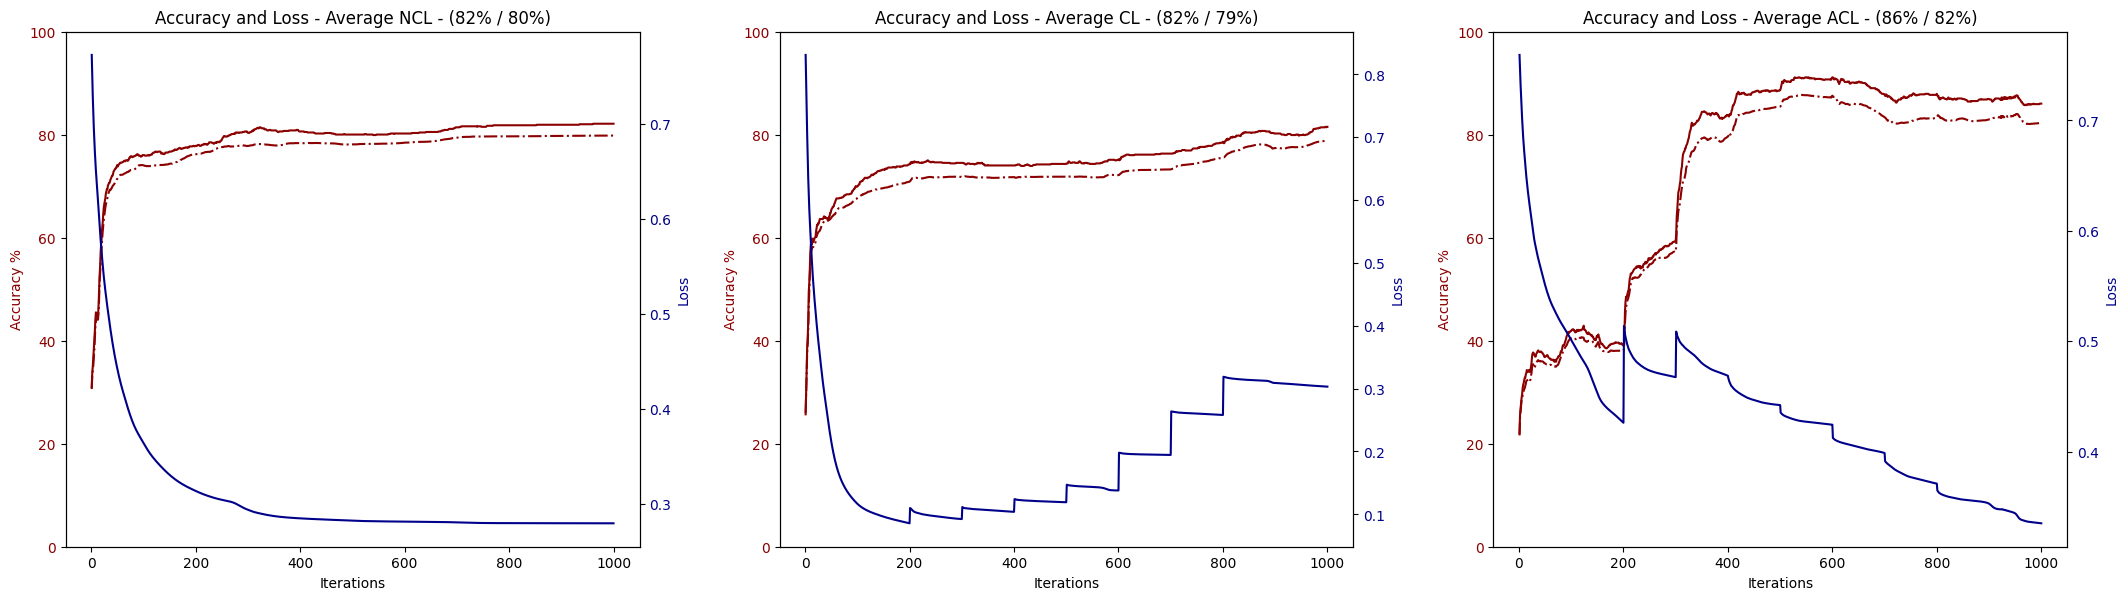

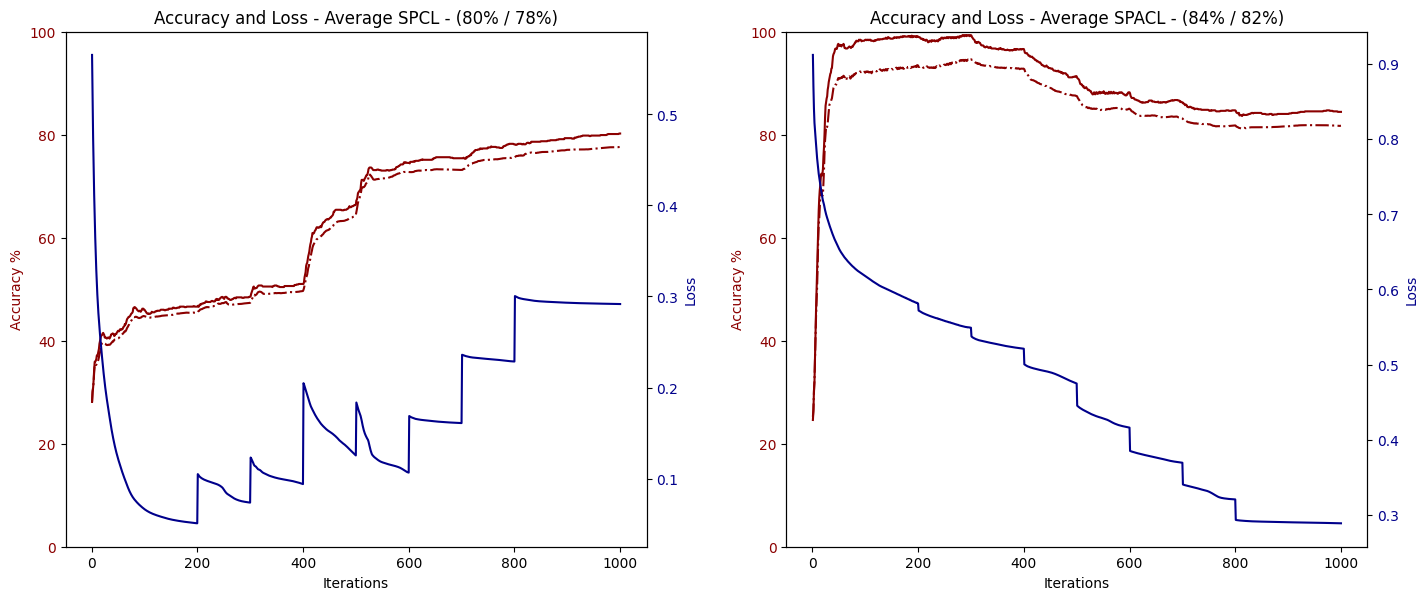

In [6]:
nqubits = 8
num_iters = 1000
num_runs = 10
time_now = "2024-01-30 22-55-44"

arr_file_names = [["NCL","CL","ACL"], ["SPCL","SPACL"]]

for file_names in arr_file_names:

        fig, axis = plt.subplots(1,len(file_names))
        fig.set_figheight(6)
        fig.set_figwidth(7*len(file_names))
        fig.tight_layout(pad=2, w_pad=7)

        i = 0
        for file_name in file_names:

                folder_name = f"Results/{nqubits}q - {num_iters:} iters"
                data_file_name = f"{folder_name}/{time_now} - Data - {file_name}.csv"

                # Read the saved data #####################
                read_data = pd.read_csv(data_file_name,
                                        usecols=["losses",
                                                "acc_train",
                                                "acc_val"],
                                        converters={"losses":ast.literal_eval,
                                                "acc_train":ast.literal_eval,
                                                "acc_val":ast.literal_eval})

                all_runs_losses = map(np.array, read_data["losses"])
                all_runs_acc_train = map(np.array, read_data["acc_train"])
                all_runs_acc_val = map(np.array, read_data["acc_val"])

                # We take the averages
                losses = sum(all_runs_losses)/num_runs
                acc_train = sum(all_runs_acc_train)/num_runs
                acc_val = sum(all_runs_acc_val)/num_runs

                iterations = range(1, num_iters+1)

                color1 = 'darkred'
                axis[i].set_xlabel('Iterations')
                axis[i].set_ylabel('Accuracy %', color=color1)
                axis[i].plot(iterations, acc_train, label="Training", color=color1)
                axis[i].plot(iterations, acc_val, '-.', label="Validation", color=color1)
                axis[i].tick_params(axis='y', labelcolor=color1)
                axis[i].set_ylim(0,100)

                ax2 = axis[i].twinx()  # instantiate a second axes that shares the same x-axis

                color2 = 'darkblue'
                ax2.set_ylabel('Loss', color=color2)  # we already handled the x-label with axis[0]
                ax2.plot(iterations, losses, label="Loss", color=color2)
                ax2.tick_params(axis='y', labelcolor=color2)
                # ax2.set_ylim(bottom=0)

                # fig.tight_layout()  # otherwise the right y-label is slightly clipped
                # plt.legend()
                axis[i].set_title(f"Accuracy and Loss - Average {file_name} - ({round(acc_train[num_iters-1])}% / {round(acc_val[num_iters-1])}%)")
                
                i += 1
                
        plt.show()
        
